<a href="https://colab.research.google.com/github/Danysan1/ai-unibo-nlp-project/blob/main/a1/execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/Danysan1/ai-unibo-nlp-project/blob/main/a1/execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assigment 1 execution

Corpora: https://www.nltk.org/nltk_data/ , point 91, "Dependency Parsed Treebank" ([link](https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip)).

Docs:
* https://www.nltk.org/api/nltk.corpus.html
* https://www.nltk.org/data.html
* https://www.nltk.org/install.html

## Preparing the environment

In [2]:
%pip install pandas numpy matplotlib gensim tensorflow-addons

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os, shutil  #  file management
import sys 
import pandas as pd  #  dataframe management
import numpy as np  #  data manipulation
import re
import urllib.request  # download files
from zipfile import ZipFile # extract files
from matplotlib import pyplot as plt
import tensorflow_addons as tfa

/opt/anaconda3/envs/nlp/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


## Downloading the dataset

In [4]:
#from nltk import download
#download()

In [5]:
dataset_folder = os.path.join(os.getcwd(), "Dataset")

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

url = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip'

dataset_path = os.path.join(dataset_folder, "dependency_treebank.zip")

if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(url, dataset_path)
    print("Successful download")
    
with ZipFile(dataset_path, 'r') as zObject:
  # Extracting all the members of the zip  into a specific location.
  zObject.extractall(dataset_folder)
  print("Successful extraction")

Successful extraction


## Loading the data

In [6]:
#from nltk.corpus import dependency_treebank
#from nltk.data import load
#dependency_treebank_test = load("nltk:") 
#sentences = dependency_treebank.sents()
#words = dependency_treebank.words()

In [7]:
def loadCorpus(start, stop=None):
    '''
    Loads the data for the specified file range.
    
    Removes the third column 'num', which is not necessary for this task.

    Parameters:
        start: start of numeric range of files (inclusive)
        stop: end of numeric range of files (exclusive)
    '''
    dataset_name = "dependency_treebank"
    folder = os.path.join(os.getcwd(), "Dataset", dataset_name)

    if stop==None:
        stop = start+1
    
    return pd.concat([
        pd.read_csv(
            f'{folder}/wsj_{"{:04d}".format(num)}.dp',
            sep="\t",
            usecols=[0,1],
            names=["word","label"]
        ) for num in range(start, stop)
    ])

In [8]:
full_dataset = loadCorpus(1,200)

## Exploratory Data Analysis

In [9]:
full_dataset.count()

word     94084
label    94084
dtype: int64

In [10]:
full_dataset.head(10)

,word,label
0,Pierre,NNP
1,Vinken,NNP
2,",",","
3,61,CD
4,years,NNS
5,old,JJ
6,",",","
7,will,MD
8,join,VB
9,the,DT


Each document contains a different tokenized article:

In [11]:
" ".join(loadCorpus(1)["word"])

'Pierre Vinken , 61 years old , will join the board as a nonexecutive director Nov. 29 . Mr. Vinken is chairman of Elsevier N.V. , the Dutch publishing group .'

In [12]:
" ".join(loadCorpus(2)["word"])

'Rudolph Agnew , 55 years old and former chairman of Consolidated Gold Fields PLC , was named a nonexecutive director of this British industrial conglomerate .'

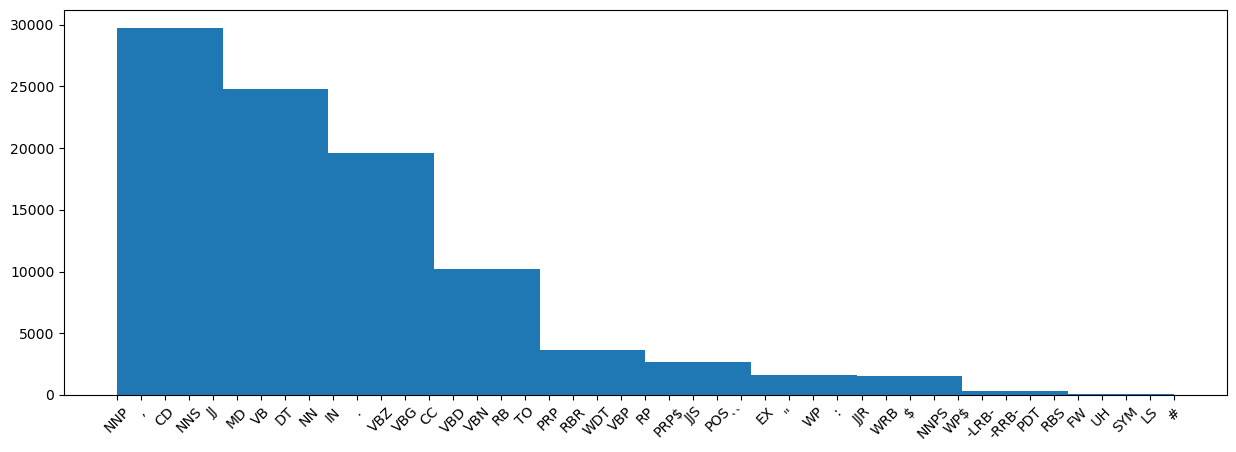

In [13]:
fig=plt.figure(figsize=(15,5))
p = plt.hist(full_dataset["label"])
plt.xticks(rotation=45)
plt.show()

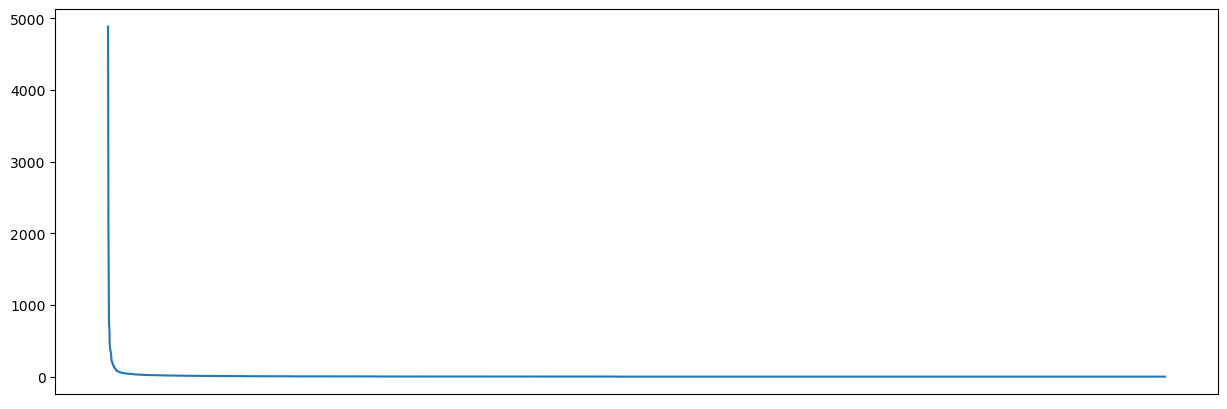

In [14]:
fig=plt.figure(figsize=(15,5))
p = plt.plot(full_dataset["word"].value_counts())
plt.xticks([])
plt.show()

## Data splitting





Creation of train, validation and test sets.

In [15]:
df_train = loadCorpus(1,101) 
df_val = loadCorpus(101,151)
df_test = loadCorpus(151,200)

df_train.count()

word     47356
label    47356
dtype: int64

In [16]:
df_val.count()

word     31183
label    31183
dtype: int64

In [17]:
df_test.count()

word     15545
label    15545
dtype: int64

## Data pre-processing

Clean the data.

In [18]:
def cleanCorpus(corpus):
    corpus['word'] = corpus['word'].str.lower()
    corpus["word"] = [re.sub(r'[^\w]', '', word) for word in corpus["word"]]
    corpus = corpus[corpus["word"] != ""]
    return corpus

In [19]:
#cleaned dataframes
dfc_train = cleanCorpus(df_train)
dfc_val = cleanCorpus(df_val)
dfc_test = cleanCorpus(df_test)

dfc_train.count()

word     41149
label    41149
dtype: int64

In [20]:
dfc_val.count()

word     27263
label    27263
dtype: int64

In [21]:
dfc_test.count()

word     13614
label    13614
dtype: int64

In [22]:
dfc_train.head(10)

,word,label
0,pierre,NNP
1,vinken,NNP
3,61,CD
4,years,NNS
5,old,JJ
7,will,MD
8,join,VB
9,the,DT
10,board,NN
11,as,IN


## Word embedding

### Loading GloVe


Loading pre-trained dense word embedding: Glove.






In [23]:
import gensim
import gensim.downloader as gloader

def load_embedding_model(model_type: str,
                         embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    download_path = ""
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"

    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    elif model_type.strip().lower() == 'fasttext':
        download_path = "fasttext-wiki-news-subwords-300"
    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove, fasttext")
        
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        print('FastText: 300')
        raise e

    return emb_model

In [24]:
# Modify these variables as you wish!
# Glove -> 50, 100, 200, 300
# Word2Vec -> 300
# Fasttext -> 300
embedding_model = load_embedding_model(model_type="glove", embedding_dimension=50)

### Analyzing OOV statistics

In [25]:
embedding_model.index_to_key[0:10]

['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s"]

In [26]:
oov_train = list(set([word for word in dfc_train.word.values if word not in embedding_model.index_to_key]))
oov_val = list(set([word for word in dfc_val.word.values if word not in embedding_model.index_to_key]))

len(oov_train)

535

In [27]:
len(oov_val)

305

In [28]:
oov_train[0:10]

['mortgagebacked',
 'lessserious',
 'uzimodel',
 'greenmailer',
 '8300s',
 'biondisanti',
 '11762',
 'boorse',
 '2512',
 '3288453']

### Embedding with GloVe

#### Prepare the embedding matrix

Definition of a tokenizer.

In [29]:
from tensorflow.keras.preprocessing.text import Tokenizer

# define the tokenizer
tokenizer = Tokenizer(oov_token='<unk>')
text = dfc_train.word.values

#fit the tokenizer on the training data
tokenizer.fit_on_texts(text)

# number of unique words in dict.
print("Number of unique words in dictionary=", len(tokenizer.word_index))
print("Dictionary head: ", dict(list(tokenizer.word_index.items())[0:10]))
with open('./word_index.json','w') as word_index_file:
    word_index_file.write(tokenizer.to_json())

Number of unique words in dictionary= 7305
Dictionary head:  {'<unk>': 1, 'the': 2, 'of': 3, 'a': 4, 'to': 5, 'in': 6, 'and': 7, 'for': 8, 's': 9, 'that': 10}


Define the embedding matrix.

In [30]:
from tqdm import tqdm

def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx,
                           vocab_size: int) -> np.ndarray:
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary
    

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)
    for word, idx in tqdm(tokenizer.word_index.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            #print(f"Using random vector for '{word}'")
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [31]:
# Testing
embedding_dimension = 50
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = build_embedding_matrix(embedding_model, embedding_dimension, tokenizer.word_index, vocab_size )
print(f"Embedding matrix shape: {embedding_matrix.shape}")

100%|██████████| 7305/7305 [00:00<00:00, 224040.94it/s]

Embedding matrix shape: (7306, 50)


#### Encode the dataset

Define a label encoder for the target class.

In [32]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

le = LabelEncoder()
dfc_train['encoded_label'] = le.fit_transform(dfc_train['label'])
dfc_val['encoded_label'] = le.transform(dfc_val['label'])
dfc_test['encoded_label'] = le.transform(dfc_test['label'])

/opt/anaconda3/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [33]:
dfc_train.head(10)

,word,label,encoded_label
0,pierre,NNP,16
1,vinken,NNP,16
3,61,CD,5
4,years,NNS,18
5,old,JJ,10
7,will,MD,14
8,join,VB,29
9,the,DT,6
10,board,NN,15
11,as,IN,9


Transform the text into a sequence of integers using the tokenizer defined before. 

In [34]:
x_train = np.array(tokenizer.texts_to_sequences(dfc_train.word.values)) 
y_train =np.array( dfc_train['encoded_label'])

x_val = np.array(tokenizer.texts_to_sequences(dfc_val.word.values))
y_val = np.array(dfc_val['encoded_label'])

x_test = np.array(tokenizer.texts_to_sequences(dfc_test.word.values))
y_test = np.array(dfc_test['encoded_label'])

#number of unique labels
num_classes = len(np.unique(y_train))
num_classes


39

In [35]:

vocab_size = len(tokenizer.word_index) + 1
vocab_size

7306

Pad the sequences to make them of same length before passing them to the model.

In [36]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(x_train, maxlen=1, padding='post')
x_val = pad_sequences(x_val, maxlen=1, padding='post')
x_test = pad_sequences(x_test, maxlen=1, padding='post')

#Train
print(f'X train shape: {x_train.shape}')
print(f'Y train shape: {y_train.shape}')
print(f'type:{type(x_train)}')

# Val
print(f'X val shape: {x_val.shape}')
print(f'Y val shape: {y_val.shape}')
print(f'type:{type(y_train)}')
# Test

print(f'X test shape: {x_test.shape}', x_test.shape)
print(f'Y test shape: {y_test.shape}', y_test.shape)

X train shape: (41149, 1)
Y train shape: (41149,)
type:<class 'numpy.ndarray'>
X val shape: (27263, 1)
Y val shape: (27263,)
type:<class 'numpy.ndarray'>
X test shape: (13614, 1) (13614, 1)
Y test shape: (13614,) (13614,)


## Baseline model: LSTM

### Define the model

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional 

model = Sequential()
embedding_layer = Embedding(input_dim = vocab_size,output_dim= embedding_dimension,input_length=1, weights = [embedding_matrix], trainable = False)
model.add(embedding_layer)
model.add(Bidirectional(LSTM(32)))
model.add(Dense(num_classes,activation='softmax'))

model.summary()

2022-12-07 18:15:38.167377: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 18:15:38.168095: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-07 18:15:38.168263: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-12-07 18:15:38.168388: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-12-07 18:15:38.168494: W tensorflow/c

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 50)             365300    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               21248     
 l)                                                              
                                                                 
 dense (Dense)               (None, 39)                2535      
                                                                 
Total params: 389,083
Trainable params: 23,783
Non-trainable params: 365,300
_________________________________________________________________


In [39]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [40]:
# fit model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size = 64, epochs=30)

Epoch 1/30
643/643 [==============================] - 9s 7ms/step - loss: 1.8659 - accuracy: 0.5193 - val_loss: 1.3441 - val_accuracy: 0.6154
Epoch 2/30
643/643 [==============================] - 4s 6ms/step - loss: 1.0383 - accuracy: 0.7024 - val_loss: 1.0912 - val_accuracy: 0.6715
Epoch 3/30
643/643 [==============================] - 4s 6ms/step - loss: 0.8530 - accuracy: 0.7503 - val_loss: 0.9877 - val_accuracy: 0.7107
Epoch 4/30
643/643 [==============================] - 4s 6ms/step - loss: 0.7548 - accuracy: 0.7834 - val_loss: 0.9262 - val_accuracy: 0.7262
Epoch 5/30
643/643 [==============================] - 4s 6ms/step - loss: 0.6891 - accuracy: 0.8007 - val_loss: 0.8929 - val_accuracy: 0.7378
Epoch 6/30
643/643 [==============================] - 3s 5ms/step - loss: 0.6401 - accuracy: 0.8124 - val_loss: 0.8671 - val_accuracy: 0.7343
Epoch 7/30
643/643 [==============================] - 3s 5ms/step - loss: 0.6022 - accuracy: 0.8214 - val_loss: 0.8559 - val_accuracy: 0.7374
Epoch 

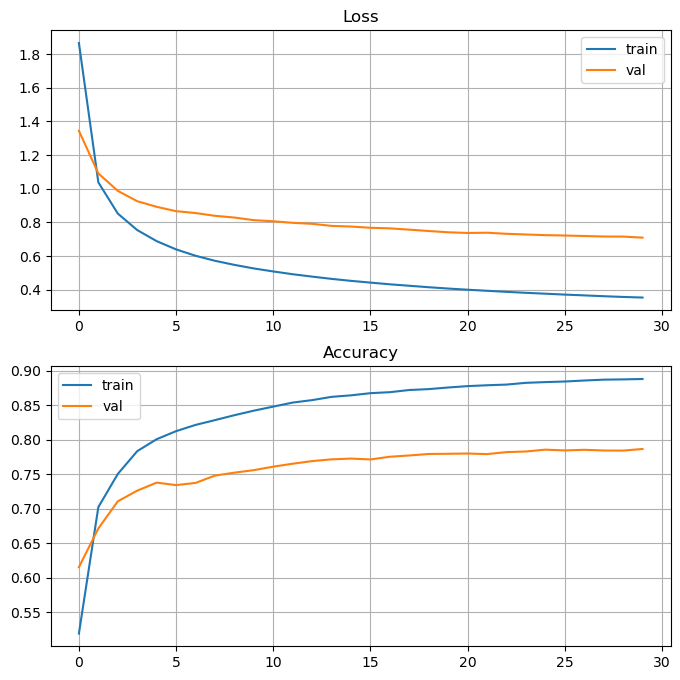

In [41]:
plt.figure(figsize=(8,8))

plt.subplot(211)
plt.grid(True)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()


plt.subplot(212)
plt.grid(True)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()

plt.show()

In [42]:
model.evaluate(x_val, y_val)

852/852 [==============================] - 3s 3ms/step - loss: 0.7099 - accuracy: 0.7866


[0.7098780274391174, 0.7865971922874451]

### F1-Macro evaluation

In [43]:
#predictions on the test data
y_pred = model.predict(x_test)

426/426 [==============================] - 2s 3ms/step


In [44]:
n = np.shape(y_pred)[0]
score = [np.argmax(y_pred[x,:]) for x in range(0,n)]

In [45]:
from sklearn.metrics import f1_score, accuracy_score
f1 = f1_score(y_test, score, average ='macro')
print(f'F1_score is: {f1}')

F1_score is: 0.7322405494347497


In [46]:
y_val.shape

(27263,)

In [47]:
onehot = OneHotEncoder(sparse=False)
onehot.fit(y_train.reshape(-1,1))
y_val_onehot = onehot.transform(y_val.reshape(-1,1))
y_val_onehot.shape

(27263, 39)

In [48]:
y_pred_val = model.predict(x_val)
y_pred_val.shape

852/852 [==============================] - 2s 3ms/step


(27263, 39)

In [49]:
# https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/F1Score
f1_macro = tfa.metrics.F1Score(average="macro", num_classes=num_classes, threshold=0.5)
f1_macro.update_state(y_val_onehot, y_pred_val)
f1_macro.result()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


<tf.Tensor: shape=(), dtype=float32, numpy=0.642281>

## Model A: GRU

GRU is a simpler alternative to LSTM's architecture, less effective but with a faster train.
</br>Two layers architecture: a Bidirectional GRU layer and a Dense/FC layer on top. 

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GRU, Bidirectional

gru_model = Sequential()
embedding_layer = Embedding(input_dim = vocab_size, 
                            output_dim = embedding_dimension, 
                            input_length = 1,
                            weights = [embedding_matrix],
                            trainable = False)

gru_model.add(embedding_layer)
gru_model.add(Bidirectional(GRU(32)))
gru_model.add(Dense(num_classes, activation='softmax'))

gru_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1, 50)             365300    
                                                                 
 bidirectional_8 (Bidirectio  (None, 64)               16128     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 39)                2535      
                                                                 
Total params: 383,963
Trainable params: 18,663
Non-trainable params: 365,300
_________________________________________________________________


In [83]:
## From Tutorial 2
## A simple plot function, could be used in any model to avoid redundancy

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from functools import partial
import random
from keras.callbacks import History

def show_history(history: History):
    """
    Shows training history data stored by the History Keras callback

    :param history: History Keras callback
    """
    history_data = history.history
    print(f"Displaying the following history keys: {history_data.keys()}")

    for key, value in history_data.items():
        if not key.startswith('val'):
            fig, ax = plt.subplots(1, 1)
            ax.set_title(key)
            ax.plot(value)
            if f'val_{key}' in history_data:
                ax.plot(history_data[f'val_{key}'])
            else:
                print(f"Couldn't find validation values for metric: {key}")

            ax.set_ylabel(key)
            ax.set_xlabel('epoch')
            ax.legend(['train', 'val'], loc='best')
        plt.grid(True)
    plt.show()

In [ ]:
from keras.optimizers import Adam
from keras.metrics import SparseCategoricalAccuracy

gru_model.compile(optimizer=Adam(learning_rate=1e-3), 
                loss='sparse_categorical_crossentropy',
                metrics=[SparseCategoricalAccuracy()])

In [ ]:
history = gru_model.fit(x=x_train, y=y_train, 
                        validation_data=(x_val,y_val),
                        verbose=1,
                        epochs=30,
                        batch_size=64)

Epoch 1/30
643/643 [==============================] - 3s 2ms/step - loss: 1.7098 - sparse_categorical_accuracy: 0.5463 - val_loss: 1.2780 - val_sparse_categorical_accuracy: 0.6337
Epoch 2/30
643/643 [==============================] - 1s 2ms/step - loss: 1.0048 - sparse_categorical_accuracy: 0.7085 - val_loss: 1.1033 - val_sparse_categorical_accuracy: 0.6712
Epoch 3/30
643/643 [==============================] - 1s 2ms/step - loss: 0.8509 - sparse_categorical_accuracy: 0.7487 - val_loss: 1.0230 - val_sparse_categorical_accuracy: 0.7012
Epoch 4/30
643/643 [==============================] - 1s 2ms/step - loss: 0.7606 - sparse_categorical_accuracy: 0.7766 - val_loss: 0.9652 - val_sparse_categorical_accuracy: 0.7291
Epoch 5/30
643/643 [==============================] - 1s 2ms/step - loss: 0.6972 - sparse_categorical_accuracy: 0.7948 - val_loss: 0.9276 - val_sparse_categorical_accuracy: 0.7238
Epoch 6/30
643/643 [==============================] - 1s 2ms/step - loss: 0.6490 - sparse_categorica

Displaying the following history keys: dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


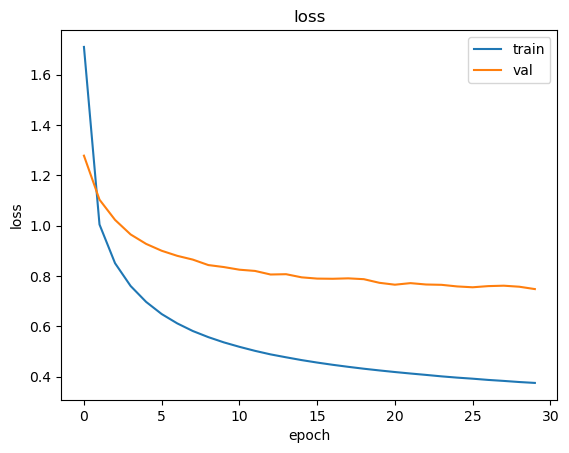

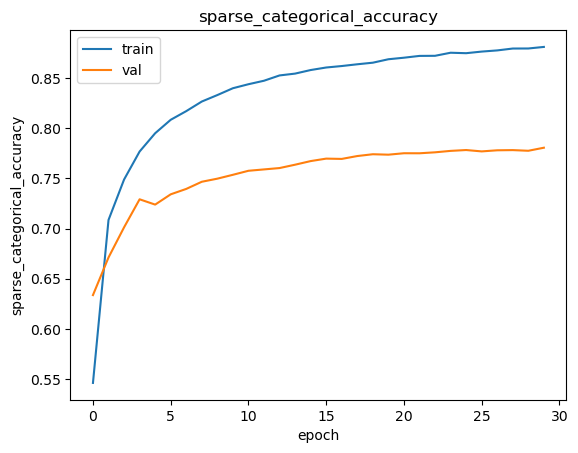

In [ ]:
show_history(history)

## Model B: 2x LSTM 

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional 

x2lstm_model = Sequential()
embedding_layer = Embedding(input_dim = vocab_size,output_dim= embedding_dimension,input_length=1, weights = [embedding_matrix], trainable = False)
x2lstm_model.add(embedding_layer)
x2lstm_model.add(Bidirectional(LSTM(14, return_sequences=True)))
x2lstm_model.add(Bidirectional(LSTM(28)))
x2lstm_model.add(Dense(num_classes,activation='softmax'))

x2lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1, 50)             365300    
                                                                 
 bidirectional_6 (Bidirectio  (None, 1, 28)            7280      
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 56)               12768     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 39)                2223      
                                                                 
Total params: 387,571
Trainable params: 22,271
Non-trainable params: 365,300
_________________________________________________________________


In [69]:
from keras.optimizers import Adam

x2lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=1.5e-3), metrics=['accuracy'])

In [70]:
# fit model
history = x2lstm_model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size = 128, epochs=30)

Epoch 1/30
322/322 [==============================] - 8s 9ms/step - loss: 2.1534 - accuracy: 0.4321 - val_loss: 1.4435 - val_accuracy: 0.5864
Epoch 2/30
322/322 [==============================] - 2s 6ms/step - loss: 1.1327 - accuracy: 0.6772 - val_loss: 1.1648 - val_accuracy: 0.6492
Epoch 3/30
322/322 [==============================] - 2s 5ms/step - loss: 0.9189 - accuracy: 0.7280 - val_loss: 1.0403 - val_accuracy: 0.6973
Epoch 4/30
322/322 [==============================] - 2s 6ms/step - loss: 0.8066 - accuracy: 0.7644 - val_loss: 0.9714 - val_accuracy: 0.7137
Epoch 5/30
322/322 [==============================] - 2s 7ms/step - loss: 0.7346 - accuracy: 0.7825 - val_loss: 0.9389 - val_accuracy: 0.7233
Epoch 6/30
322/322 [==============================] - 2s 6ms/step - loss: 0.6837 - accuracy: 0.7946 - val_loss: 0.9077 - val_accuracy: 0.7238
Epoch 7/30
322/322 [==============================] - 2s 6ms/step - loss: 0.6446 - accuracy: 0.8046 - val_loss: 0.8910 - val_accuracy: 0.7325
Epoch 

Displaying the following history keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


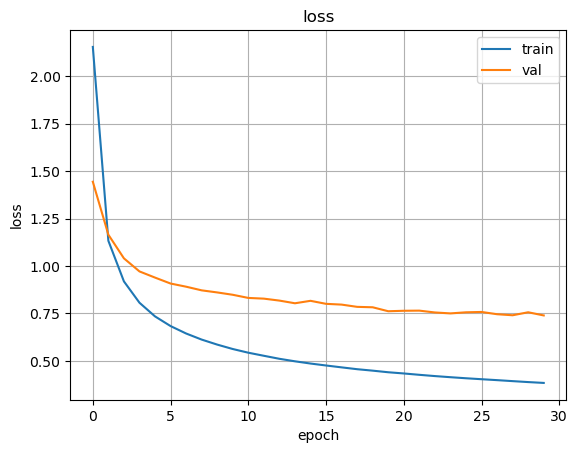

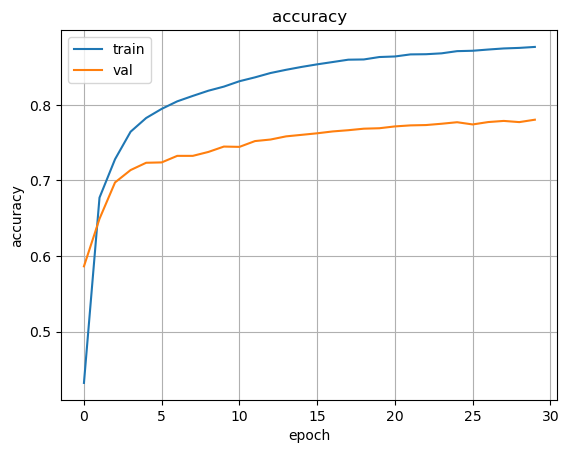

In [84]:
show_history(history)

In [72]:
x2lstm_model.evaluate(x_val, y_val)

852/852 [==============================] - 2s 2ms/step - loss: 0.7397 - accuracy: 0.7803


[0.739660918712616, 0.7802882790565491]

### F1-Macro evaluation

In [73]:
#predictions on the test data
y_pred = x2lstm_model.predict(x_test)

426/426 [==============================] - 2s 2ms/step


In [74]:
n = np.shape(y_pred)[0]
score = [np.argmax(y_pred[x,:]) for x in range(0,n)]

In [75]:
from sklearn.metrics import f1_score, accuracy_score
f1 = f1_score(y_test, score, average ='macro')
print(f'F1_score is: {f1}')

F1_score is: 0.735390117796231


In [76]:
y_val.shape

(27263,)

In [77]:
onehot = OneHotEncoder(sparse=False)
onehot.fit(y_train.reshape(-1,1))
y_val_onehot = onehot.transform(y_val.reshape(-1,1))
y_val_onehot.shape

(27263, 39)

In [78]:
y_pred_val = x2lstm_model.predict(x_val)
y_pred_val.shape

852/852 [==============================] - 1s 2ms/step


(27263, 39)

In [79]:
# https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/F1Score
f1_macro = tfa.metrics.F1Score(average="macro", num_classes=num_classes, threshold=0.5)
f1_macro.update_state(y_val_onehot, y_pred_val)
f1_macro.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.6487662>

## Model C: LSTM + Dense

## Conclusions